<a href="https://colab.research.google.com/github/anishasahu/fem-helmholtz-eqn/blob/main/notebooks/2D_soln_dirichlet_conditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install gmsh wandb
!apt-get update && apt-get install -y libglu1-mesa

In [ ]:
import wandb
from google.colab import userdata

key = userdata.get("WANDB_API_KEY")

wandb.login(key=key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import sys

import gmsh
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import interp1d
from scipy.special import (  # Bessel functions of the first and second kind
    h1vp,
    hankel1,
    j0,
    jvp,
    y0,
)

In [ ]:
def create_mesh(num_elements, inner_radius=1.0, outer_radius=2.0):
    """
    Creates a 2D quadrilateral mesh for a circular region using Gmsh.

    Parameters:
    num_elements (int): Number of elements along the radial direction.
    inner_radius (float): Radius of the inner boundary.
    outer_radius (float): Radius of the outer boundary.

    Returns:
    tuple: (element size, node coordinates, element connectivity)
    """
    # Initialize Gmsh
    gmsh.initialize(sys.argv)

    # Compute approximate element size
    radial_distance = outer_radius - inner_radius
    h = radial_distance / num_elements

    # Create a new model
    gmsh.model.add("circular_region")

    # Define the inner and outer circles
    inner_circle = gmsh.model.occ.addCircle(0, 0, 0, inner_radius)
    inner_loop = gmsh.model.occ.addCurveLoop([inner_circle])

    outer_circle = gmsh.model.occ.addCircle(0, 0, 0, outer_radius)
    outer_loop = gmsh.model.occ.addCurveLoop([outer_circle])

    # Define the surface region between the two circles
    surface = gmsh.model.occ.addPlaneSurface([outer_loop, inner_loop])

    # Synchronize the CAD representation with Gmsh
    gmsh.model.occ.synchronize()

    # Set meshing algorithm to quadrilateral elements
    gmsh.model.mesh.setAlgorithm(2, surface, 8)
    gmsh.model.mesh.setRecombine(2, surface)

    # Set maximum mesh size
    gmsh.option.setNumber("Mesh.MeshSizeMax", h)

    # Generate the mesh
    gmsh.model.mesh.generate(2)

    # Extract mesh node coordinates and element connectivity
    node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
    elem_types, elem_tags, elem_node_tags = gmsh.model.mesh.getElements(2)

    # Process node coordinates
    coords = node_coords.reshape(-1, 3)[:, :2]
    nodes = np.array(coords)

    # Identify quadrilateral elements
    elements = None
    for i in range(len(elem_node_tags)):
        elements = (
            elem_node_tags[i].reshape(-1, 4) - 1
        )  # Adjust indices for zero-based indexing

    # Finalize Gmsh
    gmsh.finalize()

    return h, nodes, elements


def shape_functions(xi, eta):
    """
    Computes shape functions and their derivatives for quadrilateral elements.

    Parameters:
    xi, eta (float): Local coordinates in the reference element.

    Returns:
    tuple: (Shape functions, Gradients of shape functions)
    """
    bases = np.array(
        [
            (1 - xi) * (1 - eta) / 4,  # phi1
            (1 + xi) * (1 - eta) / 4,  # phi2
            (1 + xi) * (1 + eta) / 4,  # phi3
            (1 - xi) * (1 + eta) / 4,  # phi4
        ]
    )

    grad = np.array(
        [
            [-(1 - eta) / 4, (1 - eta) / 4, (1 + eta) / 4, -(1 + eta) / 4],  # dphi/dxi
            [-(1 - xi) / 4, -(1 + xi) / 4, (1 + xi) / 4, (1 - xi) / 4],  # dphi/deta
        ]
    )

    return bases, grad


# Use 2-point Gauss quadrature
gauss_points, gauss_weights = np.polynomial.legendre.leggauss(2)


def element_matrices(nodal_coords):
    """
    Computes the element stiffness and mass matrices using Gauss quadrature.

    Parameters:
    nodal_coords (ndarray): Coordinates of the element nodes.

    Returns:
    tuple: (Element stiffness matrix, Element mass matrix)
    """
    Ke = np.zeros((4, 4))
    Me = np.zeros((4, 4))

    for i, xi in enumerate(gauss_points):
        for j, eta in enumerate(gauss_points):
            bases, grad = shape_functions(xi, eta)

            # Compute Jacobian matrix
            jacobian = grad @ nodal_coords
            det_jacobian = np.linalg.det(jacobian)
            inv_jacobian = np.linalg.inv(jacobian)

            # Compute derivatives in global coordinates
            dbasis_dx = inv_jacobian @ grad

            # Compute integration weight
            weight = gauss_weights[i] * gauss_weights[j]

            # Assemble element matrices
            for m in range(4):
                for n in range(4):
                    Ke[m, n] += (
                        (dbasis_dx[:, m] @ dbasis_dx[:, n]) * det_jacobian * weight
                    )
                    Me[m, n] += bases[m] * bases[n] * det_jacobian * weight

    return Ke, Me


def assembly(N, k, h, nodes, elements):
    """
    Assembles the global stiffness and mass matrices.

    Args:
        N (int): Number of elements.
        k (float): Wave number.
        h (float): Element size.
        nodes (np.ndarray): Node coordinates.
        elements (np.ndarray): Connectivity matrix.

    Returns:
        tuple:
            - A (np.ndarray): Helmholtz system matrix.
            - b (np.ndarray): Right-hand side vector.
    """
    n_nodes = len(nodes)

    # Initialize global matrices
    K = np.zeros((n_nodes, n_nodes))
    M = np.zeros((n_nodes, n_nodes))

    # Assembly loop
    for e in range(len(elements)):
        element = elements[e]
        nodal_coords = nodes[element]

        Ke, Me = element_matrices(nodal_coords)

        # Assemble into global matrices
        for i in range(4):
            for j in range(4):
                K[element[i], element[j]] += Ke[i, j]
                M[element[i], element[j]] += Me[i, j]

    # Form the Helmholtz equation system: (-∇² + k²) u = 0
    A = -K + (k**2) * M
    b = np.zeros(n_nodes)

    return A, b


def apply_boundary_conditions(
    A, b, nodes, k, inner_radius=1.0, outer_radius=2.0, tol=1e-10
):
    """
    Applies Dirichlet boundary conditions for Helmholtz equation.

    Args:
        A (np.ndarray): System matrix.
        b (np.ndarray): Right-hand side vector.
        nodes (np.ndarray): Node coordinates.
        k (float): Wave number.
        inner_radius (float): Inner boundary radius.
        outer_radius (float): Outer boundary radius.
        tol (float): Tolerance for boundary detection.

    Returns:
        tuple:
            - A (np.ndarray): Modified system matrix.
            - b (np.ndarray): Modified right-hand side vector.
    """
    r = np.linalg.norm(nodes, axis=1)
    inner_nodes = np.abs(r - inner_radius) < tol
    outer_nodes = np.abs(r - outer_radius) < tol

    # Apply Dirichlet conditions
    # u(r=1) = 0
    A[inner_nodes] = 0
    A[inner_nodes, inner_nodes] = 1
    b[inner_nodes] = 0

    # u(r=2) = 1
    A[outer_nodes] = 0
    A[outer_nodes, outer_nodes] = 1
    b[outer_nodes] = 1

    return A, b


def analytical_solution(r, k, inner_radius=1.0, outer_radius=2.0):
    """
    Computes the analytical solution to the Helmholtz equation in an annular domain.

    Parameters:
    r (ndarray): Radial positions at which to evaluate the solution.
    nodes (ndarray): Array of node coordinates.
    k (float): Wave number.
    inner_radius (float, optional): Radius of the inner boundary (default is 1.0).
    outer_radius (float, optional): Radius of the outer boundary (default is 2.0).

    Returns:
    ndarray: Analytical solution values at the given nodes.
    """
    # Boundary conditions: u(inner_radius) = 0, u(outer_radius) = 1
    u1 = 0
    u2 = 1

    # Construct the coefficient matrix using Bessel functions
    matrix = np.array(
        [
            [j0(k * inner_radius), y0(k * inner_radius)],  # Inner boundary condition
            [j0(k * outer_radius), y0(k * outer_radius)],  # Outer boundary condition
        ]
    )

    # Right-hand side vector for boundary conditions
    rhs = np.array([u1, u2])

    # Solve the system of equations to find coefficients A and B
    A, B = np.linalg.solve(matrix, rhs)

    # Compute and return the analytical solution at all node positions
    return r, A * j0(k * r) + B * y0(k * r)


def solve_helmholtz_fem(N, k, inner_radius=1.0, outer_radius=2.0):
    """
    Solves the Helmholtz equation using the Finite Element Method (FEM).

    Parameters:
    N (int): Number of elements in the mesh.
    k (float): Wave number.
    inner_radius (float, optional): Radius of the inner boundary (default is 1.0).
    outer_radius (float, optional): Radius of the outer boundary (default is 2.0).

    Returns:
    tuple: Nodes and numerical solution values.
    """
    # Generate mesh: h (element size), nodes (coordinates), elements (connectivity)
    h, nodes, elements = create_mesh(N, inner_radius, outer_radius)

    # Assemble system matrix A and right-hand side vector b
    A, b = assembly(len(elements), k, h, nodes, elements)

    # Apply boundary conditions to modify the system equations
    A, b = apply_boundary_conditions(A, b, nodes, k, inner_radius, outer_radius)

    # Solve the linear system for numerical solution u_num
    u_num = np.linalg.solve(A, b)

    return nodes, u_num


def plot_combined_solution_3d(
    ax, r, nodes, elements, u_num, k, inner_radius, outer_radius, num_points=100
):
    """
    Plots both the numerical FEM solution and the analytical solution on the same 3D plot.
    The analytical solution is shown in red, and the numerical solution in green.
    """
    # Plot numerical solution (green)
    for element in elements:
        x = nodes[element, 0]
        y = nodes[element, 1]
        z = u_num[element]  # Numerical solution values
        verts = [list(zip(x, y, z))]
        poly = Poly3DCollection(verts, alpha=0.6, color="green")
        ax.add_collection3d(poly)

    # Get analytical solution on radial grid
    r_vals, u_analytical = analytical_solution(r, k, inner_radius, outer_radius)
    theta = np.linspace(0, 2 * np.pi, num_points)
    r_grid, theta_grid = np.meshgrid(r_vals, theta)
    x_grid = r_grid * np.cos(theta_grid)
    y_grid = r_grid * np.sin(theta_grid)
    u_grid = np.tile(u_analytical, (num_points, 1))

    # Plot analytical solution (red)
    ax.plot_surface(x_grid, y_grid, u_grid, color="red", alpha=0.5)

    # Set axis labels and title
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("u(x,y)")
    ax.set_title("Numerical (Green) vs Analytical (Red) Solution")
    ax.view_init(elev=30, azim=45)

    # Set axis limits
    ax.set_xlim([np.min(nodes[:, 0]), np.max(nodes[:, 0])])
    ax.set_ylim([np.min(nodes[:, 1]), np.max(nodes[:, 1])])
    ax.set_zlim([np.min(u_num), np.max(u_num)])


def plot_solutions_combined(
    r, nodes, elements, u_num, k, inner_radius=1.0, outer_radius=2.0, figsize=(10, 7)
):
    """
    Generates a 3D plot overlaying the numerical and analytical solutions.
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")
    plot_combined_solution_3d(
        ax, r, nodes, elements, u_num, k, inner_radius, outer_radius
    )
    plt.tight_layout()
    return fig


def compute_L2_error(k, elements, nodes, u_num):
    L2_error = 0.0

    for element in elements:
        # Extract nodal coordinates for the current element
        nodal_coords = nodes[element]
        U = u_num[element]
        error = 0.0

        for i in range(len(gauss_points)):
            xi = gauss_points[i]
            eta = gauss_points[i]
            wi = gauss_weights[i]

            # Compute shape functions and their derivatives in reference coordinates
            basis_fns, grad = shape_functions(xi, eta)

            # Compute the Jacobian matrix and its determinant
            J = grad @ nodal_coords
            detJ = np.linalg.det(J)

            # Map (xi, eta) in reference element to (x, y) in physical element
            x = np.dot(basis_fns, nodal_coords[:, 0])
            y = np.dot(basis_fns, nodal_coords[:, 1])

            # Numerical solution at (x, y)
            Ue = np.dot(basis_fns, U)

            # Analytical solution at (x, y)
            r = r = np.sqrt(x**2 + y**2)
            _, U_exact = analytical_solution(r, k)

            # Accumulate the error
            error += (U_exact - Ue) ** 2 * wi * detJ

        L2_error += error

    return np.sqrt(L2_error)


def convergence_test(k_values, N_values, inner_radius=1.0, outer_radius=2.0):
    """
    Performs a convergence test for different values of k and N.
    Computes the numerical solution and compares it with the analytical solution.
    Plots the log-log error graph to analyze convergence behavior.

    Parameters:
    k_values (list): List of wave numbers to test.
    N_values (list): List of mesh refinements (number of elements across the radius).
    inner_radius (float, optional): Inner boundary radius (default is 1.0).
    outer_radius (float, optional): Outer boundary radius (default is 2.0).
    """
    errors = {k: [] for k in k_values}
    h_values = []

    for N in N_values:
        h, nodes, elements = create_mesh(N, inner_radius, outer_radius)
        h_values.append(h)

        for i, k in enumerate(k_values):
            # Compute numerical solution
            nodes, u_num = solve_helmholtz_fem(N, k)

            # Calculate radial positions of nodes
            r = np.linalg.norm(nodes, axis=1)

            # Compute analytical solution directly at node positions
            u_exact = analytical_solution(r, k, inner_radius, outer_radius)

            # Compute L2 error norm
            error = compute_L2_error(k, elements, nodes, u_num)
            errors[k].append(error)

    # Create figure with appropriate size
    plt.figure(figsize=(10, 6))

    # Plot error curves for each k
    for k in k_values:
        log_h = np.log(h_values)
        log_error = np.log(errors[k])
        slope, intercept = np.polyfit(log_h, log_error, 1)
        print(f"Convergence rate for k = {k}: {slope:.2f}")
        plt.loglog(h_values, errors[k], "-", label=f"k = {k} (slope = {slope:.2f})")

    plt.xlabel("Element Size h")
    plt.ylabel("Relative L2 Error")
    plt.title("Convergence Test: Log-Log Error Plot")
    plt.legend()
    plt.grid(True, which="both", linewidth=0.5)
    plt.tight_layout()

    return errors, h_values

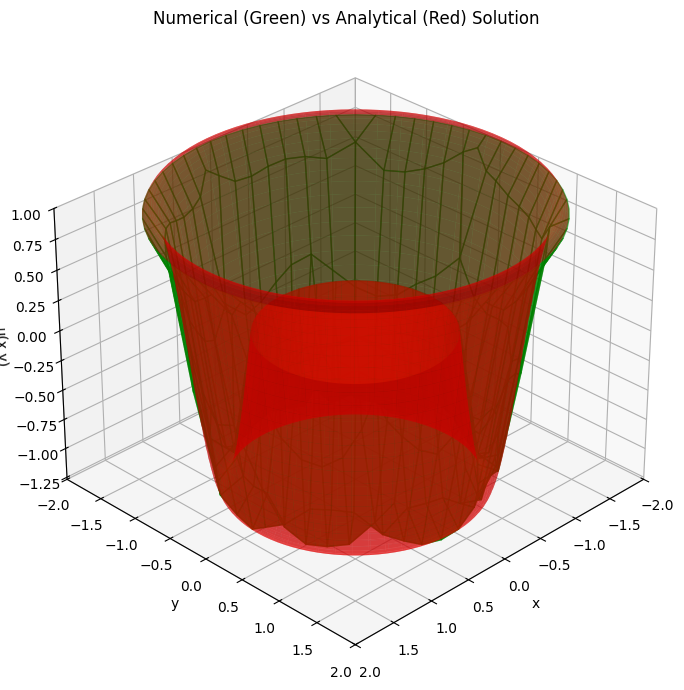

In [ ]:
# Define problem parameters
k = 5  # Wavenumber
N = 5  # Number of elements in the radial direction

# Radial grid for analytical solution
r = np.linspace(1.0, 2.0, 100)

# Generate the finite element mesh
h, nodes, elements = create_mesh(N)

# Solve the Helmholtz equation using the FEM approach
nodes, u_num = solve_helmholtz_fem(N, k)

# Plot and compare the numerical and analytical solutions
fig = plot_solutions_combined(r, nodes, elements, u_num, k)

# Display the (non-interactive) plot
plt.show()

Convergence rate for k = 1: 1.67
Convergence rate for k = 2: 1.58
Convergence rate for k = 3: 1.08
Convergence rate for k = 4: 1.77
Convergence rate for k = 5: 1.63
Convergence rate for k = 10: 0.24
Convergence rate for k = 15: 0.21
Convergence rate for k = 20: -0.68


({1: [0.04089175522221834,
   0.03922406646270988,
   0.005291849882690976,
   0.001385275369711692,
   0.0005960009328972005],
  2: [0.2540770980129385,
   0.24634219443639138,
   0.03993392110842714,
   0.010650290424352152,
   0.004651797083568642],
  3: [9.44955627718449,
   9.654673282917067,
   3.7686263281936476,
   1.217702082429948,
   0.5589750583873805],
  4: [1.5824850229091205,
   1.6407949501613779,
   0.16724051118645827,
   0.04208249259569494,
   0.019843950493313257],
  5: [2.9115887538593617,
   1.3045309379267647,
   0.27798250143335546,
   0.08226911980757756,
   0.036731469841902696],
  10: [3.6098059088116212,
   3.8975799285800545,
   5.944712807259071,
   4.761393809965957,
   1.1421027002396882],
  15: [2.8161322756873384,
   2.790794651434228,
   37.58983337469196,
   1.8093630872338533,
   1.1979298934494107],
  20: [2.9044044141076997,
   2.86424812098093,
   19.839498297592616,
   3.110727759684455,
   34.00791164752987]},
 [1.0, 0.5, 0.2, 0.1, 0.066666666

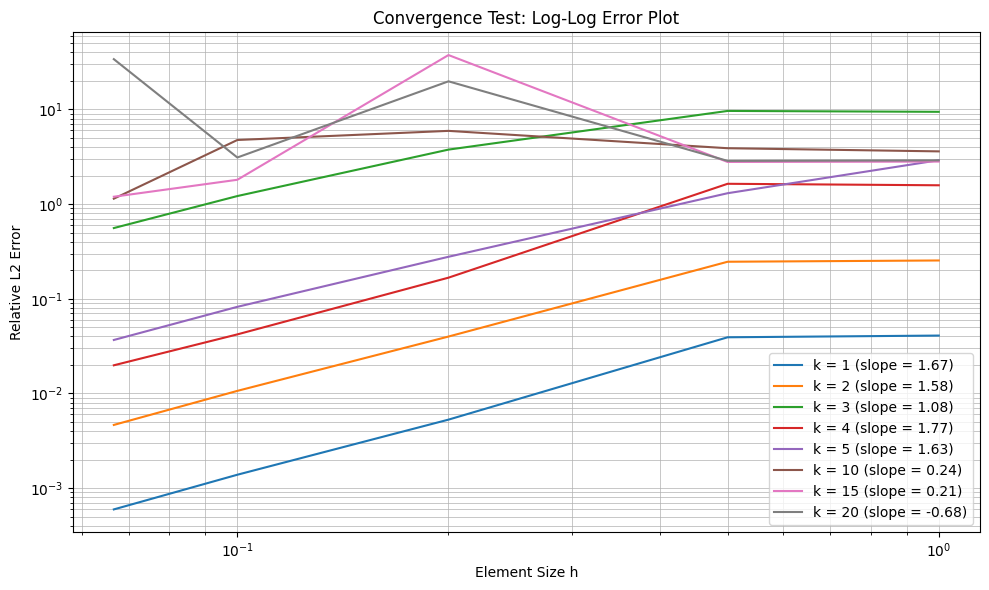

In [ ]:
# Define test values for k (wave number) and N (mesh refinement)
k_values = [1, 2, 3, 4, 5, 10, 15, 20]  # Test with different wave numbers
N_values = [1, 2, 5, 10, 15]  # Increasing mesh refinement levels

# Run convergence test
convergence_test(k_values, N_values)

In [ ]:
def plot_combined_solution_3d_plotly(
    r, nodes, elements, u_num, k, inner_radius, outer_radius, num_points=100
):
    """
    Creates an interactive 3D plot using Plotly, displaying both the numerical FEM solution and the analytical solution.
    The analytical solution is shown in red, and the numerical solution in green.
    """
    numerical_traces = []

    # Plot numerical solution (green mesh)
    for element in elements:
        x = nodes[element, 0]
        y = nodes[element, 1]
        z = u_num[element]  # Numerical solution values

        numerical_traces.append(
            go.Mesh3d(x=x, y=y, z=z, color="green", opacity=0.7, alphahull=0)
        )

    # Get analytical solution on radial grid
    r_vals, u_analytical = analytical_solution(r, k, inner_radius, outer_radius)
    theta = np.linspace(0, 2 * np.pi, num_points)
    r_grid, theta_grid = np.meshgrid(r_vals, theta)
    x_grid = r_grid * np.cos(theta_grid)
    y_grid = r_grid * np.sin(theta_grid)
    u_grid = np.tile(u_analytical, (num_points, 1))

    # Plot analytical solution (red surface)
    analytical_trace = go.Surface(
        x=x_grid,
        y=y_grid,
        z=u_grid,
        colorscale=[[0, "red"], [1, "red"]],
        opacity=0.2,
        showscale=False,
    )

    # Create figure and add traces
    fig = go.Figure(data=numerical_traces + [analytical_trace])
    fig.update_layout(
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="u(x,y)",
        ),
        title="Numerical (Green) vs Analytical (Red) Solution",
    )

    return fig

In [ ]:
# Define problem parameters
k = 5  # Wavenumber
N = 5  # Number of elements in the radial direction

# Radial grid for analytical solution
r = np.linspace(1.0, 2.0, 100)

# Generate the finite element mesh
h, nodes, elements = create_mesh(N)

# Solve the Helmholtz equation using the FEM approach
nodes, u_num = solve_helmholtz_fem(N, k)

# Plot and compare the numerical and analytical solutions
fig = plot_combined_solution_3d_plotly(r, nodes, elements, u_num, k, 1.0, 2.0)

# Display the (non-interactive) plot
plt.show()

In [ ]:
wandb.init(project="fem-helmholtz", entity="sauravmaheshkar")
wandb.log(
    {
        "Numerical Solution (Green) vs. Analyitcal Solution (Red) with Dirichlet Conditions": fig
    }
)
wandb.finish()